In [1]:
#import cell
import unittest
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchvision import ops

## Background
This paper is similar to BERT. The authors sought an alternative to CNN architecture. They achieved effects comparable to CNN and created a self-attention-based classification model. This paper remained state-of-the-art for a long time. The model was pre-trained on a large dataset before the main task. Thus, this model paved the way for downstream tasks in vision.

## Model Architecture
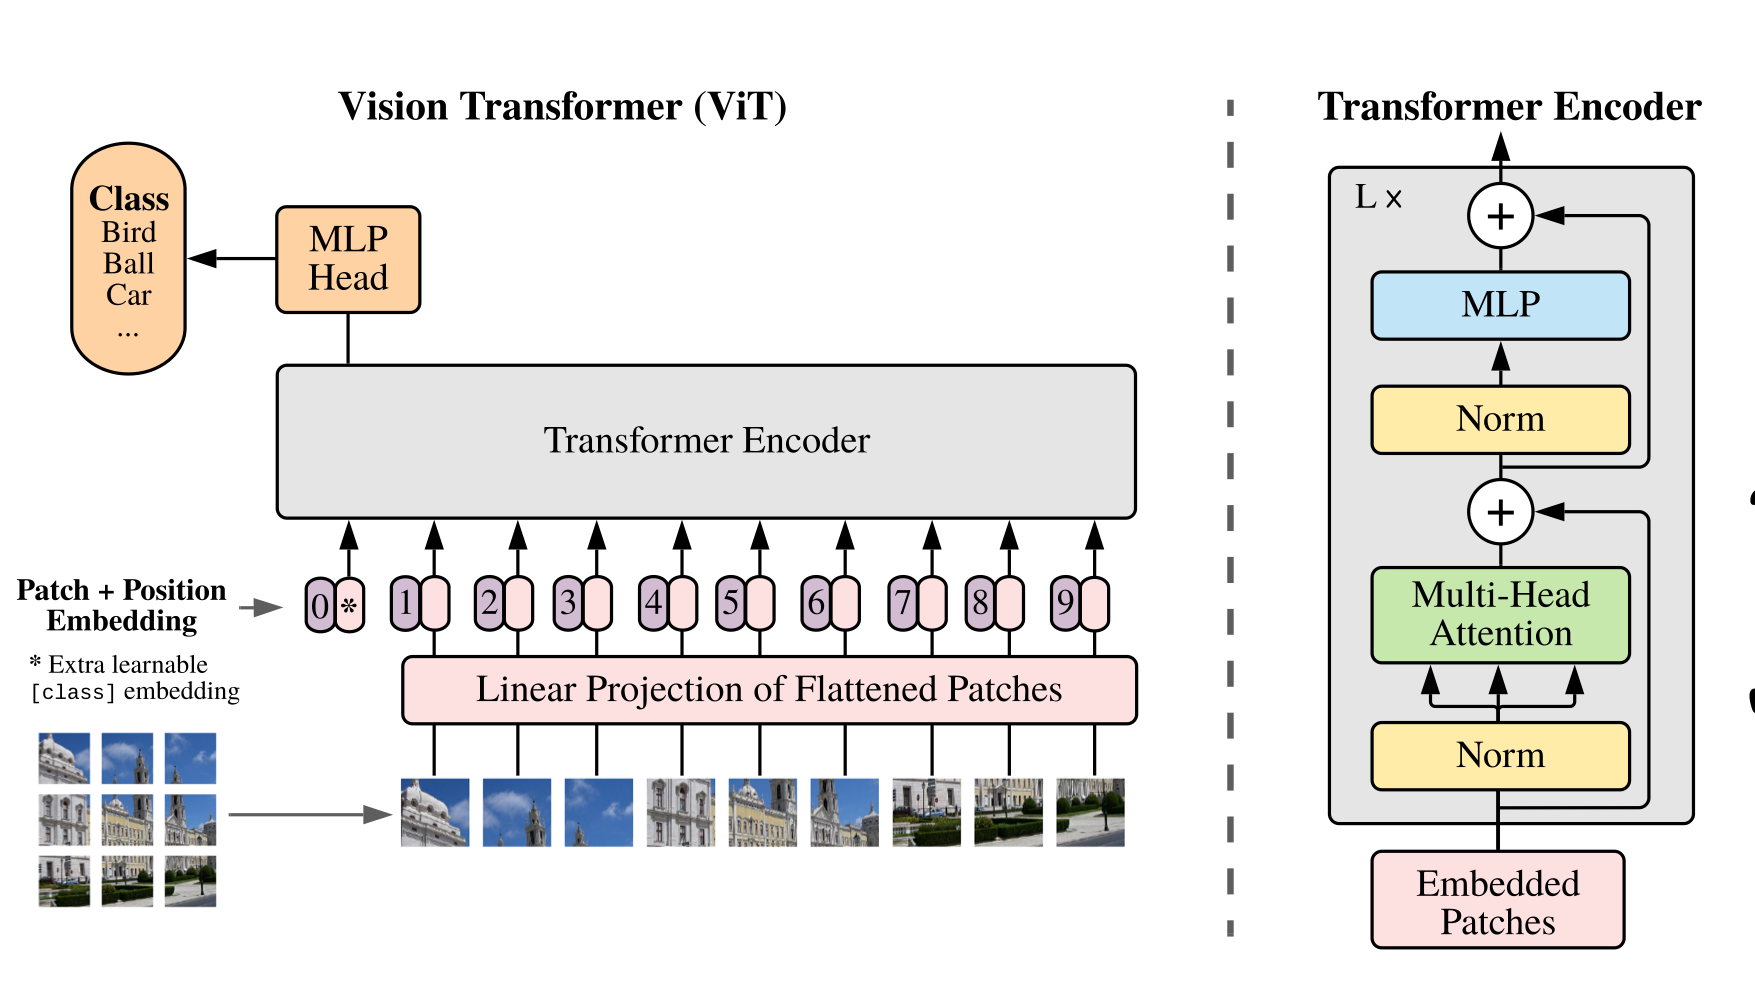

This model has a very simple structure.  
First, it follows the self-attention mechanism (from 'Attention is All You Need') in its encoder module. The image is then split to create sequence data.  
Second, it follows BERT by using a class token.  
Third, to maintain image position information, it uses position embeddings.  

## Implementation

My steps follow the paper.

### First step: Flatten the image

- They use flattened 2D patch images.
- They provide two ways to create trainable linear projections:
    1. Use Patch(P,P) and create a trainable linear projection.
    2. Use a convolution layer. This is more powerful and simpler.
- They use the position embedding and cls tocken.

In [2]:
class image_embedding(nn.Module):
    def __init__(self, image_size, patch, output_dimension, use_conv=False):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch
        self.num_patches = (image_size // patch)**2
        self.patch_dim = 3 * patch**2
        self.use_conv = use_conv
        
        if use_conv:
            self.conv_proj = nn.Conv2d(3, output_dimension, kernel_size=patch, stride=patch)
        else:
            self.linear = nn.Linear(self.patch_dim, output_dimension)
        
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, output_dimension))
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, output_dimension))
        
    def forward(self, x):
        b, c, h, w = x.size()
        
        if self.use_conv:
            x = self.conv_proj(x)  # Shape: [B, output_dimension, H/patch, W/patch]
            x = x.flatten(2).transpose(1, 2)  # Shape: [B, num_patches, output_dimension]
        else:
            x = x.reshape(b, c, h // self.patch_size, self.patch_size, w // self.patch_size, self.patch_size)
            x = x.permute(0, 2, 4, 1, 3, 5).contiguous()
            x = x.view(b, self.num_patches, self.patch_dim)
            x = self.linear(x)
        
        cls_embedding = self.cls_embedding.expand(b, -1, -1)
        x = torch.cat((cls_embedding, x), dim=1)
        x += self.pos_embedding
        return x

## Second step: Make the Transformer encoder

- This is the same as the "Attention Is All You Need" paper implementation. This paper follows it.  
- Thus, we implement 2 steps:  
    1. Overall transformer encoder architecture.  
    2. Make the layers for the architecture components.  

In [3]:
class Attention(nn.Module):
    def __init__(self, num_heads, dim):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.q_norm = nn.LayerNorm(self.head_dim)
        self.k_norm = nn.LayerNorm(self.head_dim)
        self.v_norm = nn.LayerNorm(self.head_dim)
        self.qkv = nn.Linear(dim, dim * 3)
        
        self.proj = nn.Linear(dim, dim)
        
    def forward(self, x):
        B, N, C = x.size()
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        ) # This code implements an efficient multi-head attention
        q, k, v = qkv.unbind(0) 
        q, k, v = self.q_norm(q), self.k_norm(k), self.v_norm(v)

        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = attn.softmax(dim=-1)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        
        return x

## Third step: Make the MLP head and Vit
- Finally, we have reached the stage of completing the model, and we only need to finish two things:

    1. MLP Head. This part will use torchvision.
    2.The step of combining all the modules we've made.

- These are the final steps to complete our ViT model.

In [4]:
class MLP(nn.Module):
    def __init__(
        self,
        input_dim,
        hiden_dim,
        norm_layer=None,
        activation_layer=nn.GELU,
        dropout=0.0,
    ):
        super(MLP, self).__init__()
        output_dim = [hiden_dim, input_dim]
        self.mlp_layer = ops.MLP(
            input_dim,
            output_dim,
            norm_layer=norm_layer,
            activation_layer=activation_layer,
            dropout=dropout,
        )

    def forward(self, x):
        return self.mlp_layer(x)

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(num_heads, dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), norm_layer=nn.LayerNorm, dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, num_heads, use_conv=True, mlp_ratio=4., dropout=0.):
        super().__init__()
        
        self.image_embedding = image_embedding(image_size, patch_size, dim, use_conv)
        
        self.transformer = nn.Sequential(*[
            TransformerEncoder(dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.image_embedding(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = x[:, 0]
        x = self.head(x)
        return x

# # ViT 모델 인스턴스 생성 예시
# vit = VisionTransformer(
#     image_size=224, 
#     patch_size=16, 
#     num_classes=1000, 
#     dim=768, 
#     depth=12, 
#     num_heads=12, 
#     mlp_ratio=4.0, 
#     dropout=0.1
# )

#### Use the linear for image embedding

In [6]:


vit = VisionTransformer(
    image_size=32,  
    patch_size=4,  
    num_classes=10, 
    dim=256,        
    depth=6,        
    num_heads=8,    
    mlp_ratio=2.0, 
    dropout=0.1,
    use_conv=False
)


transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

def train_one_epoch():
    vit.train()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = vit(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch: {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    end_time = time.time()
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    epoch_time = end_time - start_time

    print(f'Epoch completed in {epoch_time:.2f} seconds.')
    print(f'Epoch Loss: {epoch_loss:.4f}, Epoch Acc: {epoch_acc:.2f}%')

print("Starting training for 1 epoch...")
train_one_epoch()
print("Training completed.")

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

def evaluate():
    vit.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vit(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    print(f'Test Accuracy: {acc:.2f}%')

print("Evaluating on test set...")
evaluate()

Files already downloaded and verified
Starting training for 1 epoch...
Batch: 0, Loss: 2.4988, Acc: 7.81%
Batch: 100, Loss: 1.9590, Acc: 18.53%
Batch: 200, Loss: 1.8795, Acc: 24.11%
Batch: 300, Loss: 1.6664, Acc: 27.83%
Batch: 400, Loss: 1.4388, Acc: 30.57%
Batch: 500, Loss: 1.4397, Acc: 32.76%
Batch: 600, Loss: 1.5277, Acc: 34.44%
Batch: 700, Loss: 1.2250, Acc: 35.86%
Epoch completed in 327.21 seconds.
Epoch Loss: 1.7227, Epoch Acc: 36.92%
Training completed.
Files already downloaded and verified
Evaluating on test set...
Test Accuracy: 46.39%


#### Use the conv2d for image embedding

In [7]:

vit = VisionTransformer(
    image_size=32,  
    patch_size=4,   
    num_classes=10, 
    dim=256,        
    depth=6,        
    num_heads=8,    
    mlp_ratio=2.0,  
    dropout=0.1,
    use_conv=True
)

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # ViT 입력 크기에 맞게 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.001)

# 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

def train_one_epoch():
    vit.train()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = vit(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch: {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    end_time = time.time()
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    epoch_time = end_time - start_time

    print(f'Epoch completed in {epoch_time:.2f} seconds.')
    print(f'Epoch Loss: {epoch_loss:.4f}, Epoch Acc: {epoch_acc:.2f}%')

# 1 에폭 학습 실행
print("Starting training for 1 epoch...")
train_one_epoch()
print("Training completed.")

# 간단한 테스트 세트 평가
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

def evaluate():
    vit.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vit(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    print(f'Test Accuracy: {acc:.2f}%')

print("Evaluating on test set...")
evaluate()

Files already downloaded and verified
Starting training for 1 epoch...
Batch: 0, Loss: 2.3368, Acc: 17.19%
Batch: 100, Loss: 1.9913, Acc: 22.82%
Batch: 200, Loss: 1.4899, Acc: 27.53%
Batch: 300, Loss: 1.7630, Acc: 29.78%
Batch: 400, Loss: 1.6385, Acc: 32.01%
Batch: 500, Loss: 1.6525, Acc: 33.77%
Batch: 600, Loss: 1.5806, Acc: 35.32%
Batch: 700, Loss: 1.6480, Acc: 36.51%
Epoch completed in 328.25 seconds.
Epoch Loss: 1.7054, Epoch Acc: 37.38%
Training completed.
Files already downloaded and verified
Evaluating on test set...
Test Accuracy: 45.18%
